In [7]:
import pandas as pd
import time 
import matplotlib.pyplot as plt


        day                                    hour_file  \
0  20241221  M001_2024-12-21_00-00-00_gg-34_int-1_th.csv   
1  20241221  M001_2024-12-21_00-00-00_gg-34_int-1_th.csv   

                start_time                 end_time      mean      variance  \
0  2024/12/21 00:00:00:000  2024/12/21 00:00:00:990  1.006137  4.607076e-08   
1  2024/12/21 00:00:01:000  2024/12/21 00:00:01:990       NaN           NaN   

   log_variance  
0    -16.893087  
1           NaN  
86400
2024/12/21 00:16:40:000
2024/12/21 00:25:00:000


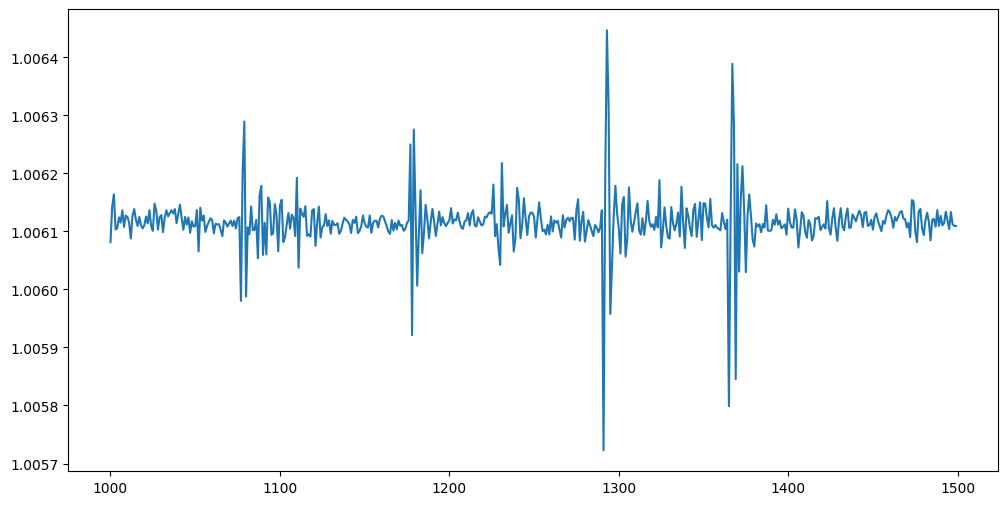

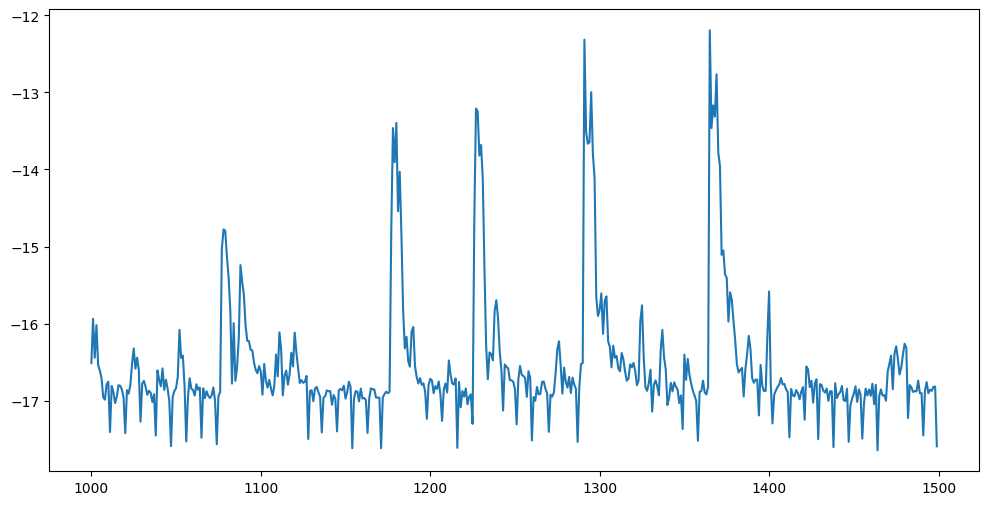

In [42]:
df = pd.read_csv('/data/pool/c8x-98x/bridge_data/100_days/20241221.csv', index_col=None)

print(df.head(2))
df= df.filter(items=['start_time', 'mean', 'log_variance'])
#df.to_string(index=False)


#df.to_csv('file.csv')
print(len(df))
print(df['start_time'][1000])
print(df['start_time'][1500])

df =df[1000:1500]
df['mean'].plot(figsize=(12, 6))
plt.show()


df['log_variance'].plot(figsize=(12, 6))
plt.show()

In [ ]:
#script t0 fileter the m,issing data
import os
import pandas as pd
from pathlib import Path

def filter_non_missing_csvs(folder_path, subfolder_name="no_missing data"):
   
    folder = Path(folder_path)
    subfolder = folder / subfolder_name
    subfolder.mkdir(exist_ok=True)

    csv_files = list(folder.glob("*.csv"))
    print(f"Found {len(csv_files)} CSV files")

    non_missing_count = 0
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            has_missing = df.isnull().any().any()

            if not has_missing:
                # Write the same data into the subfolder
                out_path = subfolder / csv_file.name
                df.to_csv(out_path, index=False)
                non_missing_count += 1
                print(f" Kept: {csv_file.name}")
            else:
                print(f" Skipped (missing data): {csv_file.name}")

        except Exception as e:
            print(f" Skipped (error reading): {csv_file.name} - {str(e)}")

    print(f"\nCompleted! {non_missing_count}/{len(csv_files)} files written to '{subfolder_name}'")

if __name__ == "__main__":
    filter_non_missing_csvs(".")

In [ ]:
import os
import pandas as pd
import numpy as np
import argparse
from tqdm import tqdm

def process_sensor_files(root_dir, sensor_name, output_dir, chunk_size=100):
    """
    Reduce frequency of sensor data by computing mean and variance every 'chunk_size' samples.
    Applies log-normal transform on variance.
    Saves one reduced CSV per day into the specified output directory.
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each day folder
    for day_folder in sorted(os.listdir(root_dir)):
        day_path = os.path.join(root_dir, day_folder)
        if not os.path.isdir(day_path):
            continue

        csv_acc_path = os.path.join(day_path, "csv_acc")
        if not os.path.exists(csv_acc_path):
            print(f"Skipping {day_folder}: no csv_acc folder found")
            continue

        print(f"\nProcessing day: {day_folder}")
        results = []

        # Process hourly CSVs inside csv_acc folder
        for file in tqdm(sorted(os.listdir(csv_acc_path)), desc=f"{day_folder}", unit="file"):
            if not file.endswith(".csv"):
                continue

            file_path = os.path.join(csv_acc_path, file)

            try:
                df = pd.read_csv(file_path, usecols=["time", sensor_name], sep=';')
            except ValueError:
                print(f"Skipping file (missing columns): {file_path}, check the column names!")
                continue

            # Compute reduced features in chunks
            for i in range(0, len(df), chunk_size):
                chunk = df.iloc[i:i + chunk_size]
                if len(chunk) < chunk_size:
                    continue  # skip incomplete chunk at end

                mean_val = chunk[sensor_name].mean()
                var_val = chunk[sensor_name].var()
                log_var = log_normal_variance(var_val)

                results.append({
                    "day": day_folder,
                    "hour_file": file,
                    "start_time": chunk["time"].iloc[0],
                    "end_time": chunk["time"].iloc[-1],
                    "mean": mean_val,
                    "variance": var_val,
                    "log_variance": log_var,
                })

        # Save the day's result to a CSV file
        if results:
            results_df = pd.DataFrame(results)
            output_path = os.path.join(output_dir, f"{day_folder}.csv")
            results_df.to_csv(output_path, index=False)
            print(f"Saved reduced CSV for {day_folder} → {output_path} ({len(results_df)} rows)")
        else:
            print(f" No valid data found for {day_folder}")



def log_normal_variance(variance):
    """Apply log-normal transform safely to variance values."""
    if variance <= 0 or pd.isna(variance):
        return np.nan
    return np.log(variance)


def main():
    parser = argparse.ArgumentParser(description="Reduce frequency of sensor CSV data (daily outputs)")
    parser.add_argument("--root_dir", type=str, required=True, help="Path to parent folder containing date folders")
    parser.add_argument("--sensor_channel", type=str, required=True, help="Sensor column name (e.g., 03091002_x)")
    parser.add_argument("--chunk_size", type=int, default=100, help="Number of samples per averaging chunk")
    parser.add_argument("--output", type=str, required=True, help="Directory to save reduced daily CSVs")

    args = parser.parse_args()
    process_sensor_files(args.root_dir, args.sensor_channel, args.output, args.chunk_size)


if __name__ == "__main__":
    main()


In [16]:
df = pd.read_parquet('/data/pool/c8x-98x/test_merge_script/20241126/20241126.parquet')
print(df.head())
print(df.tail())

                     time  03091002_x
0 2024-11-26 00:00:00.000    1.022331
1 2024-11-26 00:00:00.010    1.022461
2 2024-11-26 00:00:00.020    1.022875
3 2024-11-26 00:00:00.030    1.022477
4 2024-11-26 00:00:00.040    1.022353
                           time  03091002_x
8639995 2024-11-26 23:59:59.950    1.022468
8639996 2024-11-26 23:59:59.960    1.022270
8639997 2024-11-26 23:59:59.970    1.022537
8639998 2024-11-26 23:59:59.980    1.023083
8639999 2024-11-26 23:59:59.990    1.022657


In [ ]:

print(df.to_string(index=False))